The file is modified from its original code, with the majority of data-loading being unmodified.
The majority of explainer text is removed from the original, and the

Copyright 2020 The TensorFlow Hub Authors.
Licensed under the Apache License, Version 2.0

In [1]:
# Installs required dependencies
#!pip install -q -U tensorflow-text

# AdamW optimizer
#!pip install -q tf-models-official

In [2]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

Loads the existing data from downloaded folder.

In [3]:
#url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
#dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url, untar=True, cache_dir='.', cache_subdir='')

# The data should be in a folder the same level as the .ipynb file.
parent = os.getcwd()

dataset_dir = os.path.join(parent, 'aclImdb')
train_dir = os.path.join(dataset_dir, 'train')

# Re-running this throws an error
# remove unused folders to make it easier to load the data
# remove_dir = os.path.join(train_dir, 'unsup')
# shutil.rmtree(remove_dir)

Initial Parameters, unmodified

In [4]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


# BERT models form TensorFlow
Here is where the tutorial and the code that I wrote begins to diverge.
We start with a different choice of model to correspond to the NLP task at hand.

In [5]:
bert_model_name = 'electra_small'

handle_encoder = 'https://tfhub.dev/google/electra_small/2'
handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

print(f'BERT model selected           : {handle_encoder}')
print(f'Preprocess model auto-selected: {handle_preprocess}')

BERT model selected           : https://tfhub.dev/google/electra_small/2
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


## Pre-Processing and BERT
### If this gives an error, be sure to clear the tf_modules TEMP folder.
The model of choice is the Electra Model, which is based on BERT.
Pre-processing is given, and is typically truncated to the first 128 items.

In [6]:
bert_preprocess_model = hub.KerasLayer(handle_preprocess, name="preprocessing")
bert_model = hub.KerasLayer(handle_encoder, trainable=True, name="electra")

Verify the preprocessing and model works:

In [7]:
text_test = ['The preprocess maps text to a set of integers, similar to bag of words.']
text_preprocessed = bert_preprocess_model(text_test)
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {handle_encoder}')

print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :10]}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :10]}')

Loaded BERT: https://tfhub.dev/google/electra_small/2
Word Ids   : [  101  1996 17463  3217  9623  2015  7341  3793  2000  1037]
Pooled Outputs Values:[ 0.38453108  0.18330958 -0.5463094   0.13135742 -0.6035003  -0.07489084
  0.8030998   0.73567134  0.712655   -0.23594138]


## ML Model - Overview

The original model consisted of a preprocessing layer that feeds data into a preconfigured BERT model.
However, the weights of this BERT model are completely irrelevant to the task at hand, and therefore need to be implemented.
The tutorial fine-tuned the BERT model with a Dense Layer and a Dropout layer,
However, since we

Note: for more information about the base model's input and output you can follow the model's URL for documentation. Here specifically, you don't need to worry about it because the preprocessing model will take care of that for you.


In [28]:
def build_classifier_model():
    # Get raw text, Preprocess it, then pass it through the existing model. Functionally identical to old code.
    raw_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    inputs = bert_preprocess_model(raw_input)
    encoder = bert_model
    outputs = encoder(inputs)
    net = outputs['pooled_output']

    # Refining Layer(s)
    net = tf.keras.layers.Dense(8, activation="sigmoid", name='hidden')(net)
    net = tf.keras.layers.Dropout(0.1, name='dropout')(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(raw_input, net)

Check that the model runs with the output of the preprocessing model.

In [29]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.43451178]], shape=(1, 1), dtype=float32)


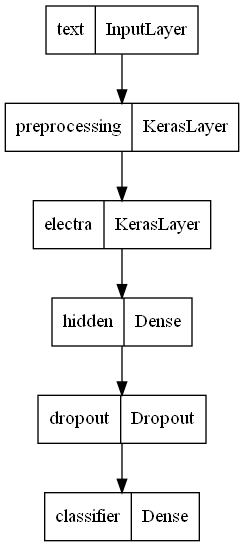

In [30]:
tf.keras.utils.plot_model(classifier_model)

## Model training

You now have all the pieces to train a model, including the preprocessing module, BERT encoder, data, and classifier.

### Loss function

Since this is a binary classification problem and the model outputs a probability (a single-unit layer), you'll use `losses.BinaryCrossentropy` loss function.


In [31]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

### Optimizer

For fine-tuning, let's use the same optimizer that BERT was originally trained with: the "Adaptive Moments" (Adam). This optimizer minimizes the prediction loss and does regularization by weight decay (not using moments), which is also known as [AdamW](https://arxiv.org/abs/1711.05101).

For the learning rate (`init_lr`), you will use the same schedule as BERT pre-training: linear decay of a notional initial learning rate, prefixed with a linear warm-up phase over the first 10% of training steps (`num_warmup_steps`). In line with the BERT paper, the initial learning rate is smaller for fine-tuning (best of 5e-5, 3e-5, 2e-5).

In [32]:
epochs = 4 # loss increases due to over-fit after ~3 epochs
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

### Loading the BERT model and training

Using the `classifier_model` you created earlier, you can compile the model with the loss, metric and optimizer.

In [33]:
classifier_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

Note: training time will vary depending on the complexity of the BERT model you have selected.

In [34]:
print(f'Training model with {handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/google/electra_small/2
Epoch 1/4
625/625 [==============================] - 236s 366ms/step - loss: 0.4157 - binary_accuracy: 0.8194 - val_loss: 0.3871 - val_binary_accuracy: 0.8596
Epoch 2/4
625/625 [==============================] - 229s 366ms/step - loss: 0.3205 - binary_accuracy: 0.8980 - val_loss: 0.4002 - val_binary_accuracy: 0.8510
Epoch 3/4
625/625 [==============================] - 229s 366ms/step - loss: 0.2927 - binary_accuracy: 0.9168 - val_loss: 0.3941 - val_binary_accuracy: 0.8544
Epoch 4/4
625/625 [==============================] - 229s 366ms/step - loss: 0.2734 - binary_accuracy: 0.9276 - val_loss: 0.3863 - val_binary_accuracy: 0.8602


### Evaluate the model

Let's see how the model performs. Two values will be returned. Loss (a number which represents the error, lower values are better), and accuracy.

In [35]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

782/782 [==============================] - 97s 124ms/step - loss: 0.3718 - binary_accuracy: 0.8697
Loss: 0.37175488471984863
Accuracy: 0.8696799874305725


### Plot the accuracy and loss over time
The following is largely unchanged, with minor edits

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


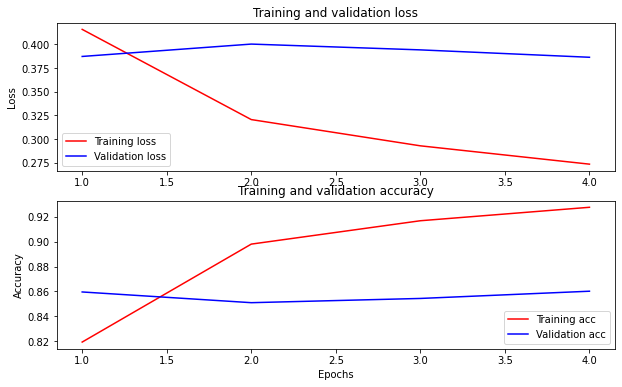

In [36]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In this plot, the red lines represent the training loss and accuracy, and the blue lines are the validation loss and accuracy.

## Export for inference

Now you just save your fine-tuned model for later use.

In [37]:
saved_model_path = './imdb_electra'
classifier_model.save(saved_model_path, include_optimizer=False)